In [1478]:
import os
import sys
import numpy as np
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

In [1479]:
def load_liveInfo(directory):
    # FileFormat
    #
    # avgParticlesPerCell: 0.145314
    # cutoff: 3.000000
    # domainSizeX: 115.000000
    # domainSizeY: 215.000000
    # domainSizeZ: 145.000000
    # estimatedNumNeighborInteractions: 289010
    # maxParticlesPerCell: 26
    # minParticlesPerCell: 0
    # numCells: 137592
    # numEmptyCells: 131716
    # numHaloParticles: 0
    # numParticles: 19994
    # particleSize: 128
    # particleSizeNeededByFunctor: 72
    # particlesPerBlurredCellStdDev: 0.359923
    # particlesPerCellStdDev: 0.018441
    # rebuildFrequency: 10
    # skin: 1.000000
    # threadCount: 12

    def parseText(text):
        data = {}
        for line in text.split("\n"):
            if len(line) > 0:
                key, value = line.split(":")
                data[key.strip()] = float(value.strip())
        return data

    with open(directory + "/live_info_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data


def load_best_configs(directory):
    # LineFormat
    #
    # Configuration: {Container: $A$ , CellSizeFactor: $B$ , Traversal: $C$ , Load Estimator: $D$ , Data Layout: $E$ , Newton 3: $F$}

    def parseText(text):
        rankings = []
        regex = r"Configuration: {Container: (.*) , CellSizeFactor: (.*) , Traversal: (.*) , Load Estimator: (.*) , Data Layout: (.*) , Newton 3: (.*)}"

        for line in text.split("\n"):
            match = re.search(regex, line)
            if match:
                data = {
                    "Container": match.group(1),
                    "CellSizeFactor": float(match.group(2)),
                    "Traversal": match.group(3),
                    "Load Estimator": match.group(4),
                    "Data Layout": match.group(5),
                    "Newton 3": match.group(6),
                }
                rankings.append(data)

        return rankings

    with open(directory + "/best_configs_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data

In [1480]:
data = {
    "src_name": [],
    # input
    "avgParticlesPerCell": [],
    "cutoff": [],
    "domainSizeX": [],
    "domainSizeY": [],
    "domainSizeZ": [],
    "estimatedNumNeighborInteractions": [],
    "maxParticlesPerCell": [],
    "minParticlesPerCell": [],
    "numCells": [],
    "numEmptyCells": [],
    "numHaloParticles": [],
    "numParticles": [],
    "particleSize": [],
    "particleSizeNeededByFunctor": [],
    "particlesPerBlurredCellStdDev": [],
    "particlesPerCellStdDev": [],
    "rebuildFrequency": [],
    "skin": [],
    "threadCount": [],
    "Ranking": [],
    # output
    "Container": [],
    "CellSizeFactor": [],
    "Traversal": [],
    "Load Estimator": [],
    "Data Layout": [],
    "Newton 3": [],
}

directories = []
for root, dirs, files in os.walk("./data/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


TOP_K_CONFIGS = 4

for directory in directories:
    liveinfo = load_liveInfo(directory)
    best_config = load_best_configs(directory)

    for i, config in enumerate(best_config[:TOP_K_CONFIGS]):
        data["src_name"].append(directory)
        data["Ranking"].append(np.exp(-i/TOP_K_CONFIGS))
        for key in config:
            data[key].append(config[key])

        for key in liveinfo:
            data[key].append(liveinfo[key])

In [1481]:
df = pd.DataFrame(data)

# save to csv
df.to_csv("combined.csv", index=False)

X = df[
    [
        "avgParticlesPerCell",
        # "cutoff",
        # "domainSizeX",
        # "domainSizeY",
        # "domainSizeZ",
        # "estimatedNumNeighborInteractions",
        "maxParticlesPerCell",
        # "minParticlesPerCell",
        # "numCells",
        # "numEmptyCells",
        # "numHaloParticles",
        # "numParticles",
        # "particleSize",
        # "particleSizeNeededByFunctor",
        # "particlesPerBlurredCellStdDev",
        "particlesPerCellStdDev",
        # "rebuildFrequency",
        # "skin",
        # "threadCount",
        "Ranking",
    ]
]

y = df[
    [
        "Container",
        # "CellSizeFactor",
        # "Traversal",
        # "Load Estimator",
        # "Data Layout",
        # "Newton 3",
    ]
]

In [1482]:
pd.concat([X, y], axis=1)

,avgParticlesPerCell,maxParticlesPerCell,particlesPerCellStdDev,Ranking,Container
0,0.141963,11.0,0.011052,1.000000,VerletListsCells
1,0.141963,11.0,0.011052,0.778801,LinkedCells
2,0.141963,11.0,0.011052,0.606531,VerletLists
3,0.141963,11.0,0.011052,0.472367,LinkedCells
4,1.680961,13.0,0.006755,1.000000,VerletListsCells
...,...,...,...,...,...
307,8.163265,28.0,0.081258,0.472367,VerletLists
308,0.081417,2.0,0.050462,1.000000,VerletClusterLists
309,0.081417,2.0,0.050462,0.778801,VerletClusterLists
310,0.081417,2.0,0.050462,0.606531,VerletClusterLists


Text(0.5, 1.0, 'Category Distribution: Container')

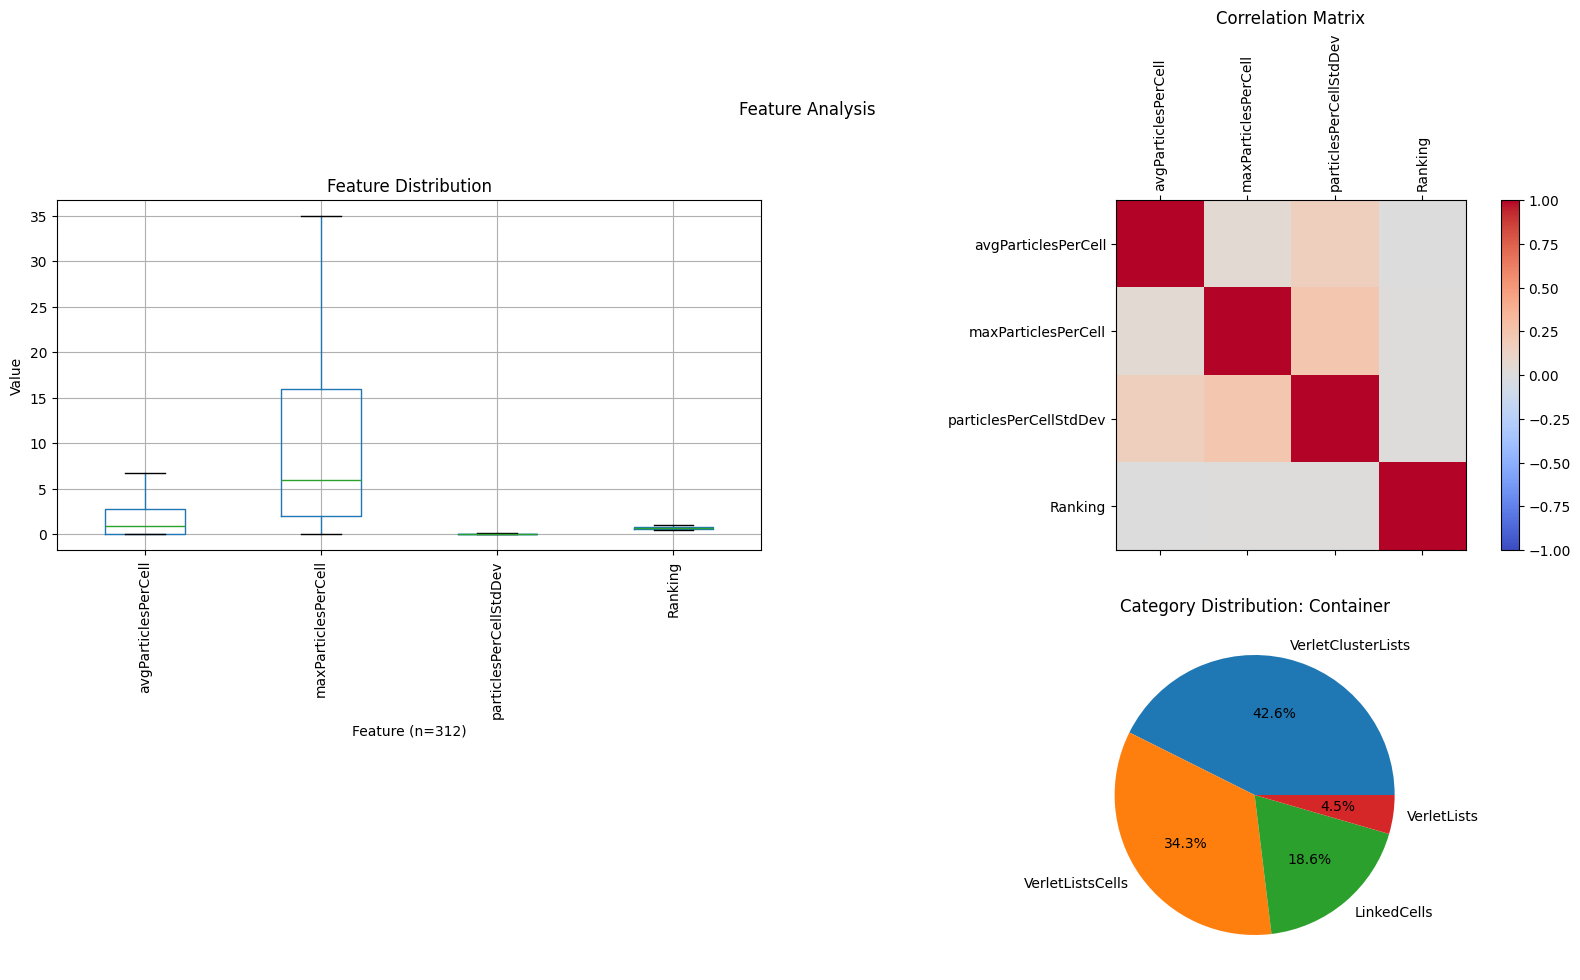

In [1483]:
corr = X.corr()

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Feature Analysis")
fig.set_figwidth(20)

# Axis 1 Boxplot for each feature

X.boxplot(ax=ax[0, 0], showfliers=False)
ax[0, 0].set_title("Feature Distribution")
ax[0, 0].set_ylabel("Value")
ax[0, 0].set_xlabel(f"Feature (n={X.shape[0]})")
ax[0, 0].set_xticklabels(X.columns, rotation=90)

# Correlation Matrix

cax = ax[0, 1].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax[0, 1].set_xticks(range(len(X.columns)))
ax[0, 1].set_yticks(range(len(X.columns)))
ax[0, 1].set_xticklabels(X.columns, rotation=90)
ax[0, 1].set_yticklabels(X.columns)
ax[0, 1].set_title("Correlation Matrix")

# hide plot
ax[1,0].axis('off')


# pi chart of category count in y

y_count = y[y.columns[0]].value_counts()
ax[1,1].pie(y_count, labels=y_count.index, autopct='%1.1f%%')
ax[1,1].set_title(f"Category Distribution: {y.columns[0]}")

# Logistic Regression to find good predictors


In [1484]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

X_train

,avgParticlesPerCell,maxParticlesPerCell,particlesPerCellStdDev,Ranking
138,1.694416,15.0,0.015635,0.606531
12,4.523221,8.0,0.002653,1.000000
27,2.486029,8.0,0.003541,0.472367
293,2.783304,6.0,0.003303,0.778801
29,0.528679,6.0,0.002912,0.778801
...,...,...,...,...
203,0.225185,1.0,0.031930,0.472367
255,6.666667,35.0,0.096717,0.472367
72,0.564113,9.0,0.007702,1.000000
235,2.826994,20.0,0.006573,0.472367


In [1485]:
model = LogisticRegression(
    max_iter=10000, solver='lbfgs', multi_class='multinomial', fit_intercept=False)

weights = X_train["Ranking"]

# drop the ranking column
X_train = X_train.drop(columns=["Ranking"])
X_test = X_test.drop(columns=["Ranking"])


model.fit(X_train, y_train, sample_weight=weights)

/home/manuel/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(fit_intercept=False, max_iter=10000,
                   multi_class='multinomial')

In [1486]:
# Evaluate model on the test set
score = model.score(X_test, y_test)

print(f"Accuracy: {score}")

Accuracy: 0.71875


# Plot Coefficients of Model


/tmp/ipykernel_186862/2849758982.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(combined_labels, rotation=90)
/tmp/ipykernel_186862/2849758982.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(combined_labels, rotation=90)
/tmp/ipykernel_186862/2849758982.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(combined_labels, rotation=90)
/tmp/ipykernel_186862/2849758982.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(combined_labels, rotation=90)


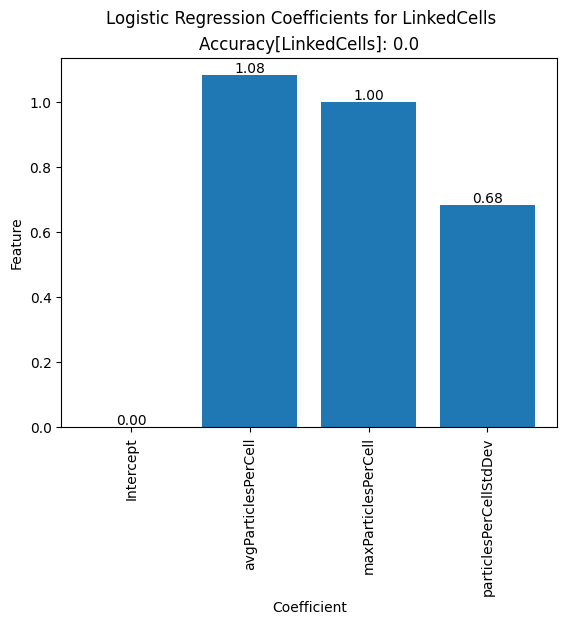

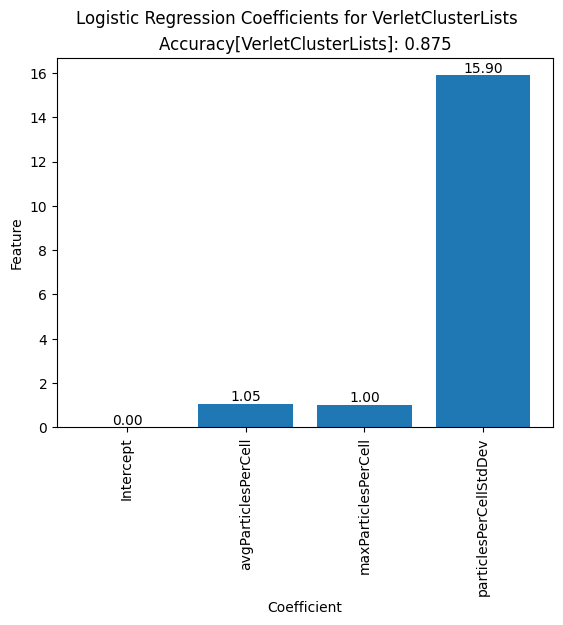

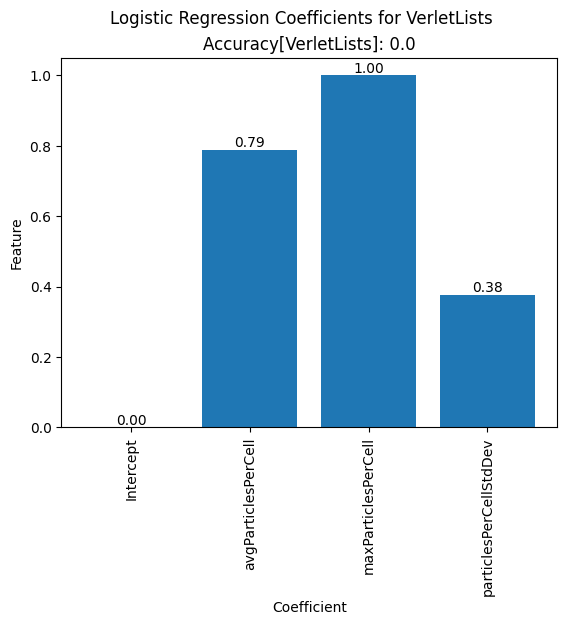

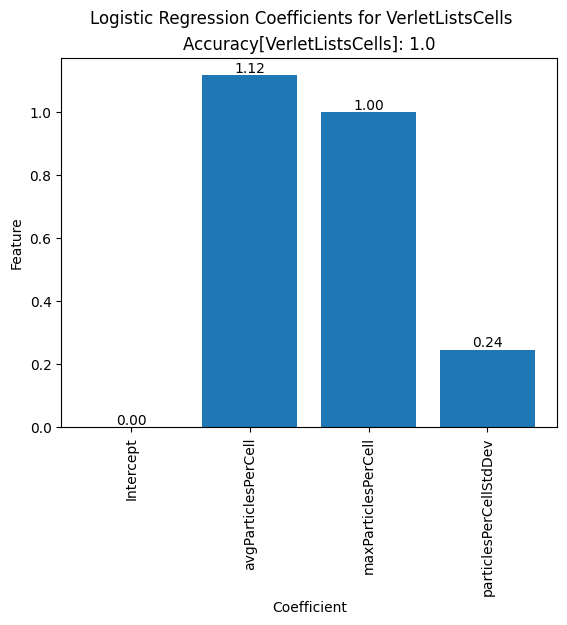

In [1487]:
for (intercept, coef_set, label) in zip(model.intercept_,  model.coef_, model.classes_):
    fig, ax = plt.subplots()
    fig.suptitle(f"Logistic Regression Coefficients for {label}")

    if (not model.get_params()['fit_intercept']):
        intercept = - np.inf

    # Axis 0 plot the coefficients
    combined_labels = ["Intercept"]+list(X_train.columns)
    combined_data = [intercept]+list(coef_set)
    odds_ratio = np.exp(combined_data)

    ax.bar(combined_labels, odds_ratio)

    # subtitles
    ax.set_xlabel("Coefficient")
    ax.set_ylabel("Feature")
    ax.axhline(0, color='black', lw=0.5, ls='--')
    ax.set_xticklabels(combined_labels, rotation=90)

    for i in range(len(odds_ratio)):
        ax.text(i, odds_ratio[i], f"{
            odds_ratio[i]:.2f}", ha='center', va='bottom')

    # accuracy
    dataX_filtered = X_test[y_test[y_test.columns[0]] == label]
    dataY_filtered = [label] * dataX_filtered.shape[0]

    score = model.score(
        dataX_filtered, dataY_filtered) if dataX_filtered.shape[0] > 0 else -1
    ax.set_title(f"Accuracy[{label}]: {score}")